<hr style="height:5px;border-width:0;color:orange;background-color:orange">
    <center> <span style="font-size: 48px;"> Medical Image Multiclass Classification - Transfer learning to computer vision </span> </center>

+ Author: **Alejandro Sánchez Silvestre**
+ Date: **Sept 2024**
+ Module: **Deep Learning**

<hr style="height:5px;border-width:0;color:orange;background-color:orange">


<a id='seccion1'></a>

# **Intro**
For the construction of the architecture of this model We've used a transfer learning using DenseNet121. Regarding the data we've obtained the ~40Gb of data from a NIH Medical Image source containing 112,120 frontal-view chest X-ray PNG images from unique 30,805 patiens. Images are in 1024*1024 resolution already classified in 14 labes:

1. Atelectasis
2. Cardiomegaly
3. Effusion
4. Infiltration
5. Mass
6. Nodule
7. Pneumonia
8. Pneumothorax
9. Consolidation
10. Edema
11. Emphysema
12. Fibrosis
13. Pleural_Thickening
14. Hernia

Each image can be labeled with multiple status at the same time.

For the spliting of Train/test the separation is made at patient level therefore patients seen in training are not seen in test to avoid data leakage.

Outline of the project:

- [0. Libraries](#0-libraries)
- [1. Data Exploration](1-data-exploration)
- [2. Train / Test Split](2-train-/-test-split)
- [3. Load the Data](#3-load-the-data)
- [4. Model built-up & Training](1-data-exploration)
- [6. Predicctions and Evaluation](1-data-exploration)
- [7. Grad-CAM: model explainability](1-data-exploration)





# **0. Libraries**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

pd.set_option('display.max_columns', 50)

In [ ]:
# Mostrar la GPU asignada
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  


REPLICAS:  8


## Acceso AWS Sagemaker a S3

In [ ]:
'''

import boto3

# Crear un cliente de S3
s3 = boto3.client('s3')

# Nombre de tu bucket
bucket_name = 'aws-medical-imaging-project'

# Listar los objetos dentro del bucket
response = s3.list_objects_v2(Bucket=bucket_name)

# Mostrar los archivos del bucket
if 'Contents' in response:
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print(f"No hay archivos en el bucket {bucket_name}.")
'''

'\n\nimport boto3\n\n# Crear un cliente de S3\ns3 = boto3.client(\'s3\')\n\n# Nombre de tu bucket\nbucket_name = \'aws-medical-imaging-project\'\n\n# Listar los objetos dentro del bucket\nresponse = s3.list_objects_v2(Bucket=bucket_name)\n\n# Mostrar los archivos del bucket\nif \'Contents\' in response:\n    for obj in response[\'Contents\']:\n        print(obj[\'Key\'])\nelse:\n    print(f"No hay archivos en el bucket {bucket_name}.")\n'

In [ ]:
'''# all_xray_df= pd.read_csv('data\Data_Entry_2017.csv') #FOR LOCAL

# all_xray_df= pd.read_csv('Data_Entry_2017.csv') # FOR COLAB

# Descargar el archivo CSV a tu instancia de JupyterLab
# s3.download_file(bucket_name, 'Data_Entry_2017.csv', '/path/to/save/Data_Entry_2017.csv')

'''
# Download the Data_Entry_2017.csv file from S3 to the current directory(sagemaker notebook instance)
# s3.download_file(bucket_name, 'Data_Entry_2017.csv', '/home/ec2-user/SageMaker/Data_Entry_2017.csv') # FOR AWS
'''
# Read the contents of the Data_Entry_2017.csv file
import pandas as pd

# all_xray_df = pd.read_csv('/home/ec2-user/SageMaker/Data_Entry_2017.csv')  # FOR AWS
all_xray_df.head()  # Ver las primeras filas del dataframe


display(all_xray_df.shape)
all_xray_df.head()
'''

"\n# Read the contents of the Data_Entry_2017.csv file\nimport pandas as pd\n\n# all_xray_df = pd.read_csv('/home/ec2-user/SageMaker/Data_Entry_2017.csv')  # FOR AWS\nall_xray_df.head()  # Ver las primeras filas del dataframe\n\n\ndisplay(all_xray_df.shape)\nall_xray_df.head()\n"

In [ ]:
# all_xray_df= pd.read_csv('data\Data_Entry_2017.csv') #FOR LOCAL

all_xray_df= pd.read_csv('Data_Entry_2017.csv') # FOR COLAB
display(all_xray_df.shape)
all_xray_df.head()


(112120, 12)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [ ]:
all_xray_df.isna().sum()

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64

In [ ]:
# drop all the observations with no finding labels as this could decrease the accuracy of the model in identifying the pathologies
all_xray_df = all_xray_df[all_xray_df['Finding Labels'] != 'No Finding']


In [ ]:
all_xray_df.shape

(51759, 12)

In [ ]:
# Convert and extract the labels into binary columns

all_list_labels= np.unique(list(all_xray_df['Finding Labels'])).tolist()

all_labels= set()
for i in all_list_labels:
    labels = i.split('|')
    for label in labels:
        all_labels.add(label)

all_labels = list(all_labels)

# Update the labels to include the binary columns

for category in all_labels:
    all_xray_df[category] = all_xray_df['Finding Labels'].apply(lambda x: 1 if category in x.split('|') else 0)

all_xray_df.sample(5)


Image Index                          Finding Labels  Follow-up #  \
82065  00020195_012.png                                  Nodule           12   
56083  00013993_139.png  Atelectasis|Consolidation|Infiltration          139   
47926  00012144_029.png             Effusion|Pleural_Thickening           29   
54762  00013689_000.png      Atelectasis|Consolidation|Effusion            0   
18463  00004904_010.png             Consolidation|Effusion|Mass           10   

       Patient ID  Patient Age Patient Gender View Position  \
82065       20195           51              M            PA   
56083       13993           44              M            AP   
47926       12144           23              F            PA   
54762       13689           20              F            PA   
18463        4904           53              F            AP   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
82065                 2826     2991                        0.143  0.143   
56083                 2500     2048                        0.168  0.168   
47926                 2992     2991                        0.143  0.143   
54762                 2992     2991                        0.143  0.143   
18463                 2500     2048                        0.171  0.171   

       Unnamed: 11  Effusion  Consolidation  Infiltration  Fibrosis  Hernia  \
82065          NaN         0              0             0         0       0   
56083          NaN         0              1             1         0       0   
47926          NaN         1              0             0         0       0   
54762          NaN         1              1             0         0       0   
18463          NaN         1              1             0         0       0   

       Atelectasis  Pneumonia  Edema  Nodule  Emphysema  Pleural_Thickening  \
82065            0          0      0       1          0                   0   
56083            1          0      0       0          0                   0   
47926            0          0      0       0          0                   1   
54762            1          0      0       0          0                   0   
18463            0          0      0       0          0                   0   

       Pneumothorax  Cardiomegaly  Mass  
82065             0             0     0  
56083             0             0     0  
47926             0             0     0  
54762             0             0     0  
18463             0             0     1

In [ ]:
all_xray_df[all_labels].sum().sort_values(ascending=False)



Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64

<Axes: >

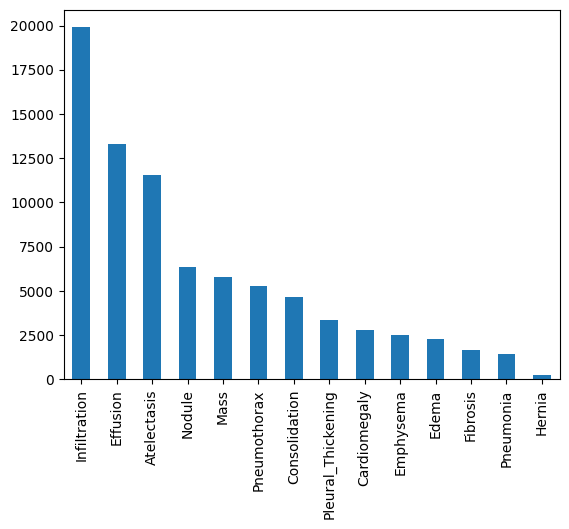

In [ ]:
all_xray_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')

# distribution of the labels is not balanced

An important class imbalance is detected along the 14 classes. DL models does not deal well with class imbalance at least we do somenthing about it. Later on we will built up a function ir order to set custom weights for the classes.

In [ ]:
# Drop Hernia class to increase accuracy in the other classes. Should it need to detect Hernia, another model only for
# hernia is advised.
# all_xray_df = all_xray_df[all_xray_df['Finding Labels'] != 'Hernia']
# all_labels.remove('Hernia')
# all_labels




# **1. Train / Test Split**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

It's very important to avoid data leakage between train&test and initially we could assume that as we are dealing with images this could potentially be imposible (at least two images are identical) we will split the train/test in a patient basis from our feature 'Patient ID'. In this manner we will secure the model generalise better and do not memorise patient paterns. Let's remember several images can be taken from an unique patient.

After the spliting we will check if there is any leakage in a patient level between train and test.

In [ ]:
# Create unique patinents.
unique_patients = all_xray_df['Patient ID'].unique()

# split in train and test

from sklearn.model_selection import train_test_split

train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

df_train_val = all_xray_df[all_xray_df['Patient ID'].isin(train_patients)]
df_test = all_xray_df[all_xray_df['Patient ID'].isin(test_patients)]

# split in train and validation
df_train_drop, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42)


# drop 50% of train data to speed up trainning.
df_train, discard = train_test_split(df_train_drop,test_size= 0.1, random_state=42)

# Check dimensions of splits
df_train.shape, df_val.shape, df_test.shape

((29854, 26), (8294, 26), (10293, 26))

In [ ]:
# Check if patients are unique in train and validation/test

train_val_patients = set(df_train_val['Patient ID'])
test_patients = set(df_test['Patient ID'])


# Check if there's overlap
common_patients = train_val_patients.intersection(test_patients)
print(f"Number of common patients: {len(common_patients)}")



Number of common patients: 0


##  **1.2 Directory image creation (only in local)**

As the image are in a particular format (110K images splited in 14 folders grouped by labels) and following the Data architectured I designed, data is splited from a dataframe and the capture from this differents dataframes. In order to do so, three folders will be made (train, val & test) in local to group the random images and then upload to S3 bucket.


In [ ]:
# solo en local

# import os

# Define the directory to save the data
# new_dir = r'C:\Master Data Science - Nuclio\Notebooks\Portfolio\Proyectos propios\AI_for_medical_diagnosis\AWS_data'
# train_dir = os.path.join(new_dir, 'train')
# val_dir = os.path.join(new_dir, 'val')
# test_dir = os.path.join(new_dir, 'test')

# Create the directories
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)





In [ ]:

# import os
# import shutil

# Ruta base donde están almacenadas todas las imágenes, con subcarpetas incluidas
# dir = r'C:\Master Data Science - Nuclio\Notebooks\Portfolio\Proyectos propios\AI_for_medical_diagnosis\data'

# def find_image_in_subfolders(base_dir, image_name):
    # Buscar la imagen en todas las subcarpetas
    # for root, dirs, files in os.walk(base_dir):
        # if image_name in files:
            # return os.path.join(root, image_name)  # Retorna la ruta completa si encuentra la imagen
    # return None  # Si no encuentra la imagen

# def copy_images(df, destination_dir, base_dir):
    # for index, row in df.iterrows():
        # Obtener el nombre del archivo de la imagen
        # image_name = row['Image Index']  # La columna 'Image Index' contiene el nombre del archivo de la imagen

        # Buscar la imagen en todas las subcarpetas
        # original_path = find_image_in_subfolders(base_dir, image_name)

        # if original_path:
            # Definir la nueva ruta de destino
            # new_path = os.path.join(destination_dir, image_name)

            # Copiar la imagen a la nueva ubicación
            # shutil.copy(original_path, new_path)

            # Imprimir el progreso opcionalmente
            # print(f"Copiando {original_path} a {new_path}")
        # else:
            # Imprimir un mensaje si la imagen no fue encontrada
            # print(f"Imagen no encontrada: {image_name}")

# Mover las imágenes de train
# copy_images(df_train, train_dir, base_dir)

# Mover las imágenes de val
# copy_images(df_val, val_dir, base_dir)

# Mover las imágenes de test
# copy_images(df_test, test_dir, base_dir)




# **3. Loading the data**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

After the spliting the three folders will be uploaded to an S3 Bucket and from there we will be accesing the files. Once we check it's working well we will implement the ImageDataGenerators used to feed the models. These data generators will be reading from the dataframe created for train,val and test and taking and transforming the images contained in the S3 Bucket.




In [ ]:
# For loading the data we will use flow_from_dataframe from Keras.



In [ ]:
# First enable the conection to the drive folder

from google.colab import drive
drive.mount('/content/drive')

# and create a function to build the correct path to the image
def path_to_image(df,folder):
  df['filepath'] = '/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/'+ folder +'/'+ df['Image Index']

# execute function
path_to_image(df_train,'train')
path_to_image(df_val,'val')
path_to_image(df_test,'test')

# validate example
df_train.filepath.sample(3)

Mounted at /content/drive


<ipython-input-20-77f464fe8bb6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filepath'] = '/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/'+ folder +'/'+ df['Image Index']


102880    /content/drive/My Drive/Data_Science_Repo_Data...
68021     /content/drive/My Drive/Data_Science_Repo_Data...
109963    /content/drive/My Drive/Data_Science_Repo_Data...
Name: filepath, dtype: object

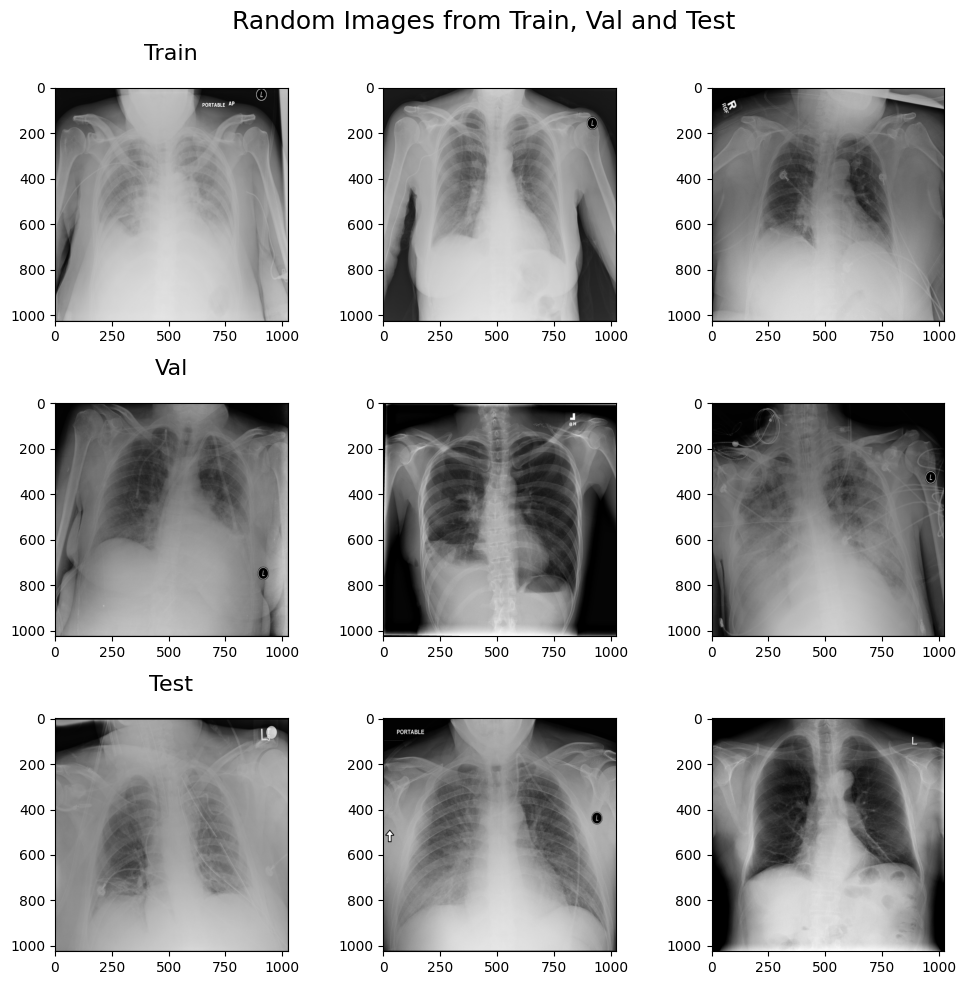

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

# Random picking of image paths
random_images_path = []
random_images_path.append(random.sample(list(df_train.filepath), 3))
random_images_path.append(random.sample(list(df_val.filepath), 3))
random_images_path.append(random.sample(list(df_test.filepath), 3))

# Flatten the list
random_images_path = [image for subset in random_images_path for image in subset]

# Row titles
row_titles = ['Train', 'Val', 'Test']

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop for visualization
for i, ax in enumerate(axes.flat):
    img = cv2.imread(random_images_path[i])  # Open image
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        ax.imshow(img_rgb)  # Show image
    else:
        ax.set_title('Error: Image not loaded')  # Set error title if image is None

    # Set title of each row
    if i % 3 == 0:
        ax.set_title(row_titles[i // 3], loc='center', fontsize=16, pad=20)

# Adjust layout and show plot
plt.suptitle('Random Images from Train, Val and Test', fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
# Check the shape of a sample image.
cv2.imread(df_train.filepath.sample(1).values[0]).shape

# 1024 px and 3 Channels (RGB but actualy greyscale)

(1024, 1024, 3)

## **Data Generators**


---
For uploading the data to the model several changes will be needed for the model correctly understand and learn from the images.

Fortunatelly keras.preprocessing has a module for thad (ImageDataGenerator) that will be used to apply this changes needed. Essencialy it normalizes each image per batch and creates changes for data augmenation (rotations, zoom...). ImageDataGenerator will deliver an image where pixel value mean will be 0 and the standard deviation is 1.

It's important to use a separate ImageDataGenerator for Train and other for Validation and test as the batch stadistics in the normalization will affect the performance of the model as we dont want to share any information in test split with the training model.


When starting the data transformation process, it is crucial to ensure that the model does not have access to any information from the test set. Knowing the batch mean of the test data could unfairly advantage the model. To prevent this, we need to normalize the incoming test data using the statistics calculated from the training set.

I implement this normalization taking a sample for calculate this stadistics from trainning data and create the ImageDataGenerator for Val and Test from here. It is worth mentioning that, ideally, we would calculate the sample mean and standard deviation using the entire training set. However, since this set is very large, doing so would be very time-consuming. Therefore, to maintain efficiency, we will take a random sample from the dataset and compute the mean and standard deviation from that sample.

The parameters to adjust will be the followings:

- Batch_size: 32 images per batch. Increasing this number could favor the model to learn better but it'll take more time to train and could lead to an overfitting.

- Sample_size: this is the number of random images taken to built up the data generator for test. In average it's set to 20% of the training data but taking into account we are dealing with 50k valid images, 1000 will be enougth to calculate this.

- target_size: 320x320 is set as DenseNet121 accept images in this format. ImageDataGenerator will transform from 1024x1024 to the desired size.


In [ ]:
# Loading the data

# from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.efficientnet import preprocess_input


# Definir funcion preprocesado, Normalizado + Standarizado por cada imagen,
# ya que no nos podemos asegurar que han sido tomadas en las mismas condiciones (misma maquina, operador, intensidad...)
'''
def manual_preprocessing(img):
    # Escalar valores de [0, 255] a [0, 1]
    img = img / 255.0

    # Normalización: estandarización, centrando alrededor de 0 con desviación estándar 1
    mean = img.mean()  # Puedes ajustar la media según tu dataset
    std = img.std()    # Puedes ajustar la desviación estándar según tu dataset

    img = (img - mean) / (std + 1e-7)  # Añadir una pequeña constante para evitar división por cero
    return img
'''


# Set the imageDataGenerator for loading the data

datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True ,  # Scalation(from 0-255 to 0-1)+Normalization (mean in 0)
    shear_range=0.1,
    rotation_range=10,  # Aumentar el rango de rotación
    width_shift_range=0.12,
    height_shift_range=0.1,
    zoom_range=0.2,  # Aumentar el zoom
    brightness_range=[0.8, 1.2],  # Aumentar el brillo
    horizontal_flip=False, #Important to set this to False
    vertical_flip= False, # As medical images
    fill_mode = 'reflect'

)



# Create the generators
# Parameters to fine tune:
# 1. Batch_size. 2. Sample Size

# as we are usin GPU A100, allows us to use up to 40Gb of GPU RAM
batch_size= 64
# Sample size about 20% of training set to capture the pixel normalization stadistics.
# sample_size = 1000 if int(df_train.shape[0] * 0.2) > 1000 else int(df_train.shape[0] * 0.2)
sample_size=100


# TRAIN
train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',  # column with the path to image
    y_col=all_labels,  # Column with labels
    target_size=(320, 320),  # adjust size
    batch_size=batch_size,  # Tamaño de lote
    class_mode='raw',  # raw for multilabel
    shuffle=True  # Barajar los datos
)


# ImageDataGenerator sin aumentación para validación y test


# get the batch normalization from train to valid and test image generator
raw_train_generator =ImageDataGenerator().flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',  # column with the path to image
    y_col=all_labels,  # Column with labels
    target_size=(320, 320),  # adjust size
    batch_size= sample_size,  # Tamaño de lote
    class_mode='raw',  # raw for multilabel
    shuffle=True  # Barajar los datos
)

# get data sample
batch = next(raw_train_generator)
data_sample = batch[0]

# use sample to fit mean and std for test set generator
datagen_no_aug = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization= True)


# fit generator to sample from training data
datagen_no_aug.fit(data_sample)



# VAL sin aumentación
val_generator = datagen_no_aug.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepath',
    y_col=all_labels,
    target_size=(320, 320),
    batch_size=64,
    class_mode='raw',
    shuffle=False  # No es necesario hacer shuffle en validación
)

# TEST sin aumentación
test_generator = datagen_no_aug.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',
    y_col=all_labels,
    target_size=(320, 320),
    batch_size=64,
    class_mode='raw',
    shuffle=False  # No es necesario hacer shuffle en test
)



Found 29854 validated image filenames.
Found 29854 validated image filenames.
Found 8294 validated image filenames.
Found 10293 validated image filenames.


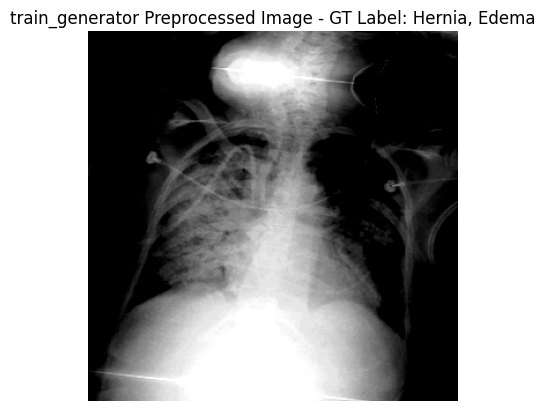

Pixel values of preprocessed image from train_generator:
Min pixel value: -3.8327515
Max pixel value: 1.5483131


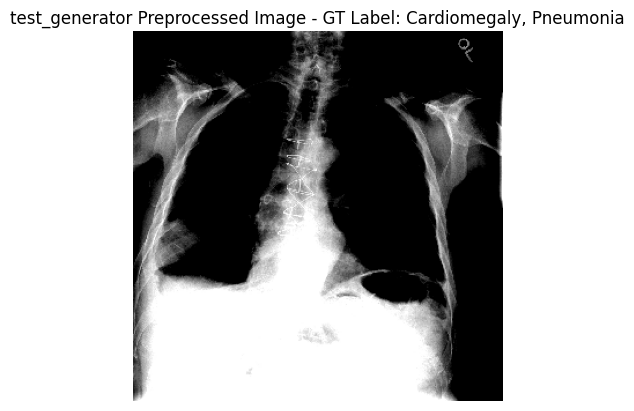

Pixel values of preprocessed image from test_generator:
Min pixel value: -1.6595446
Max pixel value: 1.7746114


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función auxiliar para convertir etiquetas binarias en texto de etiquetas
def get_label(y, all_labels):
    """
    Convierte una etiqueta binaria (0 o 1) en texto de etiquetas correspondientes.

    y: vector binario de etiquetas.
    all_labels: lista con los nombres de todas las etiquetas.
    """
    ret_labels = [all_labels[i] for i, val in enumerate(y) if val == 1]
    if not ret_labels:
        return 'No Label'
    else:
        return ', '.join(ret_labels)

# Función para chequear y mostrar UNA imagen preprocesada con etiquetas GT en el título
def check_preprocessing(generator, generator_name, all_labels):
    # Obtener un lote del generador
    batch = next(generator)

    # batch[0] contiene las imágenes, y batch[1] contiene las etiquetas
    images = batch[0]
    labels = batch[1]  # Etiquetas verdaderas (ground truth)

    # Seleccionar solo la primera imagen del batch
    img_preprocessed = images[0]
    label_text = get_label(labels[0], all_labels)  # Convertir la etiqueta binaria en texto

    # Mostrar la imagen
    plt.imshow(img_preprocessed)
    plt.axis('off')
    plt.title(f"{generator_name} Preprocessed Image - GT Label: {label_text}")
    plt.show()

    # Chequear los valores máximos y mínimos de los píxeles
    print(f"Pixel values of preprocessed image from {generator_name}:")
    print("Min pixel value:", img_preprocessed.min())
    print("Max pixel value:", img_preprocessed.max())

# Lista de etiquetas (modifica con las etiquetas correctas para tu caso)
all_labels = ["Cardiomegaly", "Fibrosis", "Hernia", "Consolidation", "Effusion",
              "Pleural_Thickening", "Nodule", "Edema", "Pneumothorax", "Infiltration",
              "Mass", "Emphysema", "Atelectasis", "Pneumonia"]

# Visualizar una imagen del train_generator
check_preprocessing(train_generator, "train_generator", all_labels)

# Visualizar una imagen del test_generator
check_preprocessing(test_generator, "test_generator", all_labels)


## Class Imbalance: custom class weight as solution
---
Deep Learning models does not deal well with class imbalance as could lead to untrusty accuracy metrics. In order to avoid this we will handle an customised function to the model to correctly set the weigths according to the classes. The lesser represented labels will have more weigth in the training than the most common labels so the model can learn beter this minnoritatian labels giving them more weight.

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies

    return positive_frequencies, negative_frequencies


freq_pos, freq_neg = compute_class_freqs(train_generator.labels)


Let's visualize the positive labels vs the negative labels along the dataset. Ideally we would have liken a balanced dataset where all the labels are present in the same proportion and the positive/negative for each class is 50/50.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


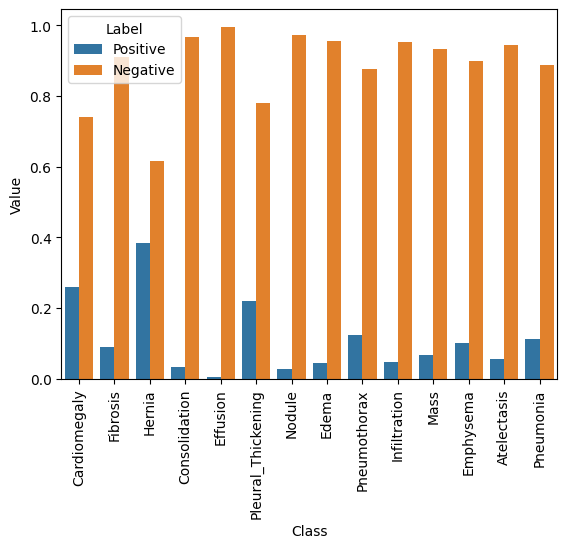

In [ ]:

labels=np.array(all_labels)

# calulating and plotting the imbalanced classes
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])
data = pd.concat([data, new_data], ignore_index=True)

# Plot
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Class', ylabel='Value'>

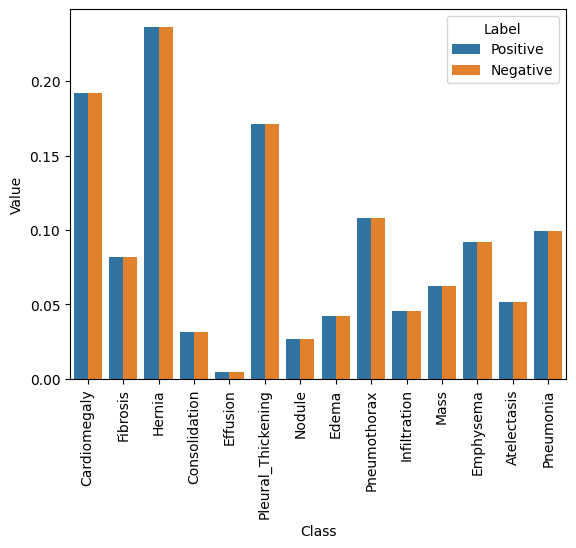

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

# Create data for positive contributions
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Create data for negative contributions and concatenate
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])
data = pd.concat([data, new_data], ignore_index=True)

# Plot
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)


In [ ]:
# CON TPU

import tensorflow.keras.backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    # Convertir los pesos a float32
    pos_weights = K.cast(pos_weights, dtype='float32')
    neg_weights = K.cast(neg_weights, dtype='float32')

    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # Convertir y_true y y_pred a float32
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')

        # inicializar la pérdida a cero
        loss = 0.0

        # Calcular la pérdida ponderada para cada clase
        for i in range(len(pos_weights)):
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg

        return loss

    return weighted_loss


In [ ]:
# CON GPU
'''

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

  '''

'\n\ndef get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):\n    """\n    Return weighted loss function given negative weights and positive weights.\n\n    Args:\n      pos_weights (np.array): array of positive weights for each class, size (num_classes)\n      neg_weights (np.array): array of negative weights for each class, size (num_classes)\n\n    Returns:\n      weighted_loss (function): weighted loss function\n    """\n    def weighted_loss(y_true, y_pred):\n        """\n        Return weighted loss value.\n\n        Args:\n            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)\n            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)\n        Returns:\n            loss (Float): overall scalar loss summed across all classes\n        """\n        # initialize loss to zero\n        loss = 0.0\n\n        for i in range(len(pos_weights)):\n            # for each class, add average weighted loss for that class


# **3. Model Built-up & Training**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

For the model built-up two candidates were proposed for transfer learning, EfficientNetB1 and DenseNet121. Both are great models for medical imaging.

- EfficientNet:More recent(2019), EfficientNet introduced a compound scaling method, optimizing accuracy and computational efficiency.State-of-the-art: It’s closer to the cutting edge in many tasks, including medical imaging, due to its balance between accuracy and efficiency (fewer parameters, better performance).High accuracy with lower computational costs, making it suitable for large datasets like medical imaging.


- DenseNet121:Older (2017) but still widely used in medical imaging tasks. Better feature reuse, known for high performance in image classification but heavier in terms of computation compared to EfficientNet.

DenseNet121 was the chosen one as per its widely use in medical image environements. Building will be very simple as it only consist in adding a pooling and a dense layer consistin in 14 Neurons as per the number of classes to be classified.

In [ ]:
# CON EFFICIENTNETB1
'''
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

# Cargar EfficientNetB1 con pesos preentrenados de ImageNet
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Añadir capas superiores para la clasificación multietiqueta
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Capa densa adicional
predictions = Dense(len(all_labels), activation='sigmoid')(x)  # N clases con activación sigmoide

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con las métricas solicitadas
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=get_weighted_loss(pos_weights, neg_weights),  # Ajusta según clases desbalanceadas
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Mostrar la arquitectura del modelo
model.summary()
'''


"\nfrom tensorflow.keras.applications import EfficientNetB1\nfrom tensorflow.keras.layers import GlobalAveragePooling2D, Dense\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.metrics import AUC, Precision, Recall\nimport tensorflow.keras.backend as K\n\n# Cargar EfficientNetB1 con pesos preentrenados de ImageNet\nbase_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(320, 320, 3))\n\n# Añadir capas superiores para la clasificación multietiqueta\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dense(1024, activation='relu')(x)  # Capa densa adicional\npredictions = Dense(len(all_labels), activation='sigmoid')(x)  # N clases con activación sigmoide\n\n# Crear el modelo completo\nmodel = Model(inputs=base_model.input, outputs=predictions)\n\n# Compilar el modelo con las métricas solicitadas\nmodel.compile(\n    optimizer=Adam(learning_rate=5e-4),\n    loss=get_weighted_loss(pos_weights, ne

In [ ]:
# CON DENSENET

from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K


# As the classes are highly imbalanced we will use other metrics too to track performance(precission, recall, and AUC)


# Cargar DenseNet121 con pesos preentrenados de ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Añadir capas superiores para la clasificación multietiqueta
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(all_labels), activation='sigmoid')(x)  # 15 clases con activación sigmoide

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con las métricas solicitadas
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=get_weighted_loss(pos_weights, neg_weights),  # Loss acording to the weighted class presence
    metrics=[
        'accuracy',               # Accuracy general
        Precision(name='precision'),  # Precisión
        Recall(name='recall'),        # Recall
        AUC(name='auc'),              # Área bajo la curva ROC
    ]
)

# Mostrar la arquitectura del modelo
model.summary()




29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

**Learning Rate Optimizer**

---
The learning rate is a crucial hyperparameter in neural network training, and adjusting it throughout the training process can improve convergence and help prevent issues like overfitting. This strategy will work as follows:

- Begginig of training: Gradually increasing the learning rate, allowing the model to stabilize more effectively.
- Intermediate epochs: Maintaining a high learning rate to optimize the model’s performance.
- Final epochs: Exponentially decreasing the learning rate to fine-tune the final adjustments and prevent the model from overshooting local minima.

This will help us to maximize learning efficiency across different phases of the training process and to achieve convergence faster.


In [ ]:
import tensorflow as tf


# optimizador de learning rate
def build_lrfn(lr_start=0.000002, lr_max=0.00010,
               lr_min=0, lr_rampup_epochs=8,
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
# creamos callbacks de guardado de modelo
from tensorflow.keras.callbacks import ModelCheckpoint

# Crear un callback para guardar el modelo cada vez que mejore
checkpoint_callback = ModelCheckpoint(
    '/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/model/model_checkpoint.keras',  # Ruta del archivo donde se guardará el modelo
    save_best_only=True,     # Guardar solo el modelo si mejora el rendimiento
    save_weights_only=False, # Guardar todo el modelo, no solo los pesos
    monitor='val_loss',      # Métrica que se monitorea para guardar el mejor modelo
    mode='min',              # Guardar cuando la métrica se minimice (ej. pérdida)
    verbose=1                # Mostrar un mensaje cada vez que se guarda
)


from tensorflow.keras.callbacks import CSVLogger

# Crear un callback para guardar los logs en un archivo CSV
csv_logger = CSVLogger('/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/model/training_log.csv', append=True)



**Training**

---

In [34]:
# Entrenamos en estos parametros para evitar un entrenamiento excesivo o muy simple
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.n // train_generator.batch_size,  #
    validation_steps=10,
    # val_generator.n // val_generator.batch_size,  # 50 pasos por cada validación
    verbose=1,  # Mostrar el progreso del entrenamiento
    # guardamos datos de cada epoch
    callbacks=[lr_schedule,checkpoint_callback,csv_logger]
    )

#DenseNet121


Epoch 1: LearningRateScheduler setting learning rate to 2e-06.
Epoch 1/10
466/466 [==============================] - ETA: 0s - loss: 1.8866 - accuracy: 0.0923 - precision: 0.1651 - recall: 0.4935 - auc: 0.6336 
Epoch 1: val_loss improved from inf to 1.86541, saving model to /content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/model/model_checkpoint.keras
466/466 [==============================] - 9245s 20s/step - loss: 1.8866 - accuracy: 0.0923 - precision: 0.1651 - recall: 0.4935 - auc: 0.6336 - val_loss: 1.8654 - val_accuracy: 0.0844 - val_precision: 0.1670 - val_recall: 0.4302 - val_auc: 0.6187 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.425e-05.
Epoch 2/10
466/466 [==============================] - ETA: 0s - loss: 1.6518 - accuracy: 0.1807 - precision: 0.1786 - recall: 0.6078 - auc: 0.6781 
Epoch 2: val_loss improved from 1.86541 to 1.59166, saving model to /content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/model/model_checkpoi

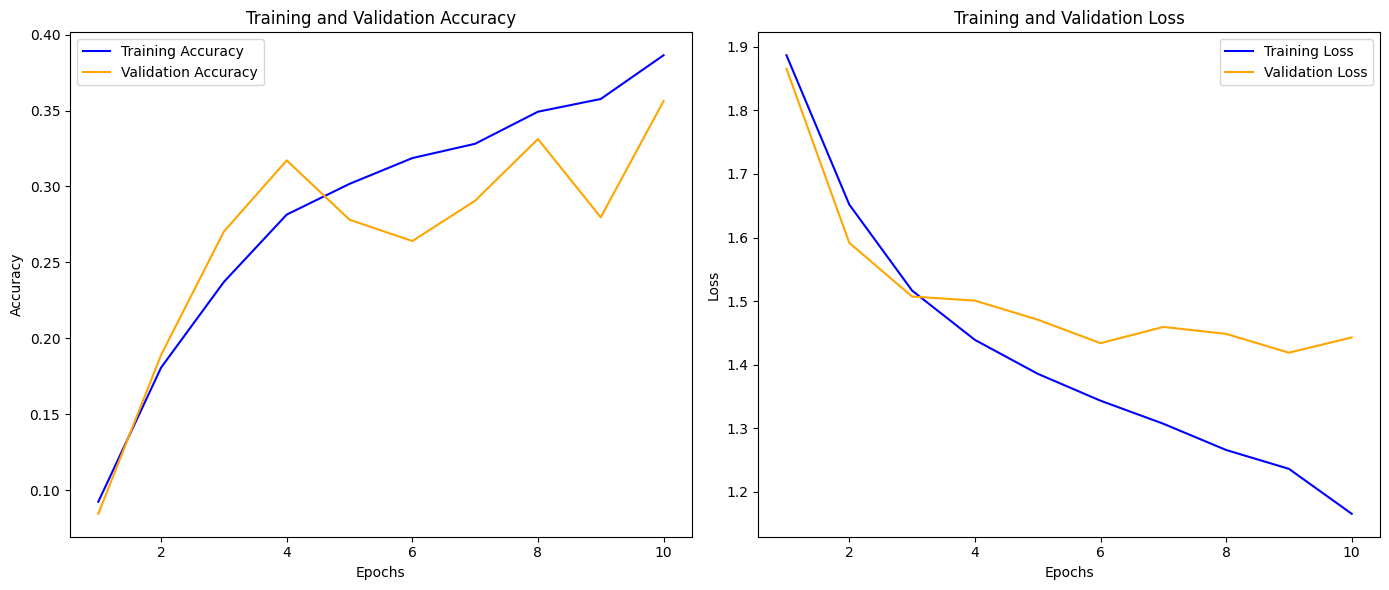

In [35]:
# VISUALIZAMOS LAS GRAFICAS DE ACCURACY Y LOSS


import matplotlib.pyplot as plt

# Acceder a los valores guardados en el history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Crear el subplot para Accuracy y Loss
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica de Accuracy
axs[0].plot(epochs, acc, label='Training Accuracy', color='blue')
axs[0].plot(epochs, val_acc, label='Validation Accuracy', color='orange')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Gráfica de Loss
axs[1].plot(epochs, loss, label='Training Loss', color='blue')
axs[1].plot(epochs, val_loss, label='Validation Loss', color='orange')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()


In [36]:
# guardamos metricas y modelo

hist_df = pd.DataFrame(history.history)
hist_df.to_csv('ultimate_metricas.csv')

# y guardamos el modelo y pesos
model.save('ultimate_model.keras')
model.save('ultimate_model_.h5')
model.save_weights('ultimate_model_trained.weights.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



# **4. Predictions and Evaluation**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [37]:
y_pred = model.predict(test_generator, verbose=1)

161/161 [==============================] - 3395s 21s/step


In [ ]:
import pickle
# Guardar las predicciones usando pickle
with open('ultimate_predictions.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

'''
# Cargar las predicciones guardadas con pickle
with open('predictions.pkl', 'rb') as f:
    y_pred_loaded = pickle.load(f)
'''

import numpy as np

# Guardar las predicciones en un archivo .npy
np.save('ultimate_predictions.npy', y_pred)
'''
# Cargar las predicciones desde el archivo .npy
y_pred_loaded = np.load('predictions.npy')
'''

In [40]:
from sklearn.metrics import classification_report

# Binarización de las predicciones (umbral de 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convierte las predicciones a 0 o 1
y_true = test_generator.labels

# Generar un informe de clasificación por clase
print(classification_report(y_true, y_pred_binary, target_names=all_labels))


                    precision    recall  f1-score   support

      Cardiomegaly       0.47      0.80      0.59      2547
          Fibrosis       0.16      0.61      0.26       928
            Hernia       0.45      0.88      0.59      3996
     Consolidation       0.11      0.45      0.18       305
          Effusion       0.06      0.57      0.10        54
Pleural_Thickening       0.46      0.61      0.52      2392
            Nodule       0.05      0.66      0.10       308
             Edema       0.12      0.87      0.21       488
      Pneumothorax       0.27      0.59      0.37      1257
      Infiltration       0.48      0.55      0.51       532
              Mass       0.13      0.63      0.22       647
         Emphysema       0.36      0.60      0.45      1041
       Atelectasis       0.20      0.73      0.31       471
         Pneumonia       0.38      0.49      0.43      1128

         micro avg       0.29      0.71      0.41     16094
         macro avg       0.26      0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

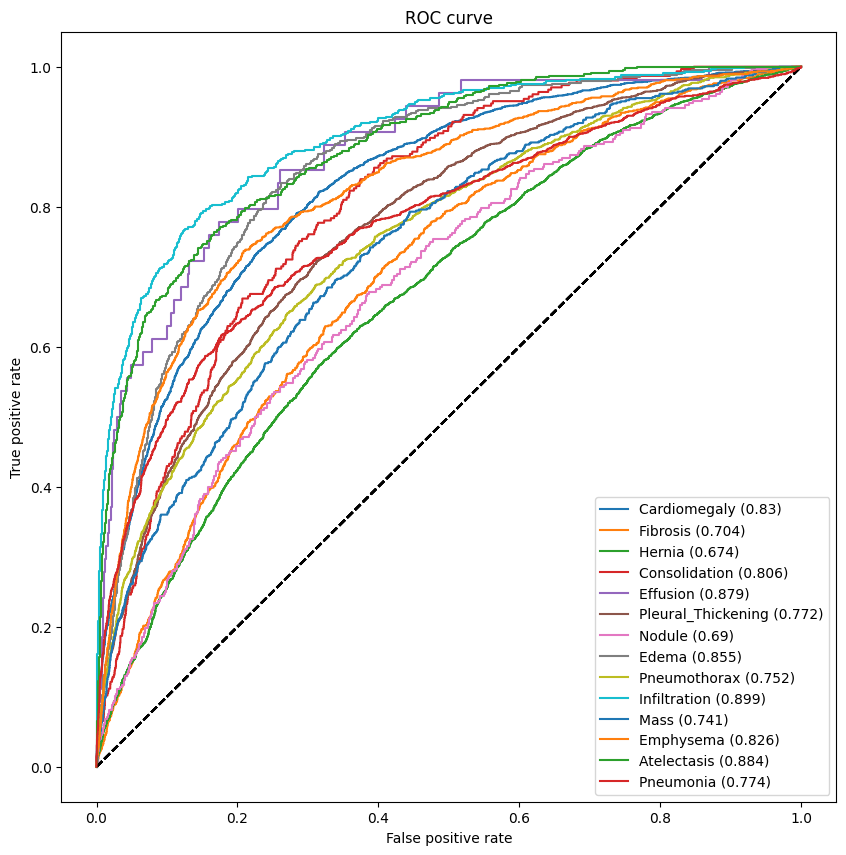

In [43]:
# 5 Oct
auc_rocs = get_roc_curve(all_labels, y_pred, test_generator)

# **PONER TABLA METRICAS CADA CLASE **

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def get_roc_curve(labels, predicted_vals, generator):
    roc_data = []  # Lista para almacenar los datos (label, auc_roc, fpr, tpr)

    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)

            # Almacenar (label, auc_roc, fpr, tpr) para ordenarlos después
            roc_data.append((labels[i], auc_roc, fpr_rf, tpr_rf))

        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )

    # Ordenar los datos según el valor AUC ROC de mayor a menor
    roc_data = sorted(roc_data, key=lambda x: x[1], reverse=True)

    # Crear el gráfico
    plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')

    # Dibujar las curvas ROC en orden
    for label, auc_roc, fpr_rf, tpr_rf in roc_data:
        plt.plot(fpr_rf, tpr_rf, label=label + " (" + str(round(auc_roc, 3)) + ")")

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.savefig('ROC.png')
    plt.show()

    return [item[1] for item in roc_data]  # Devolver solo los AUC ROC


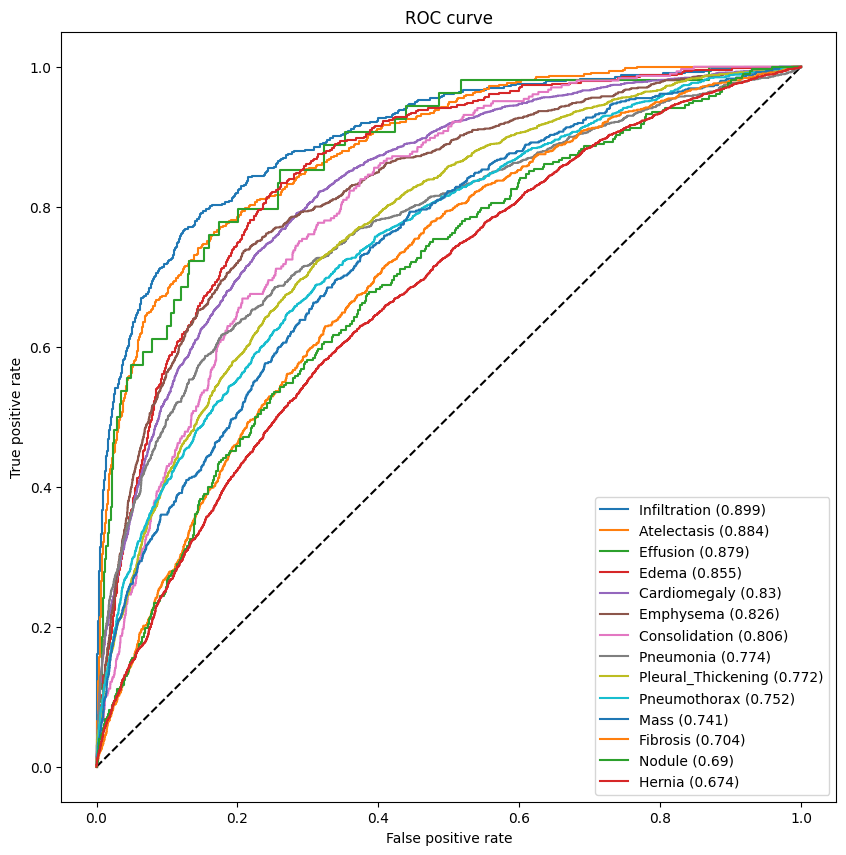

In [58]:
auc_rocs = get_roc_curve(all_labels, y_pred, test_generator)

## VISUALIZAMOS PREDICCIONES

1/1 [==============================] - 0s 183ms/step


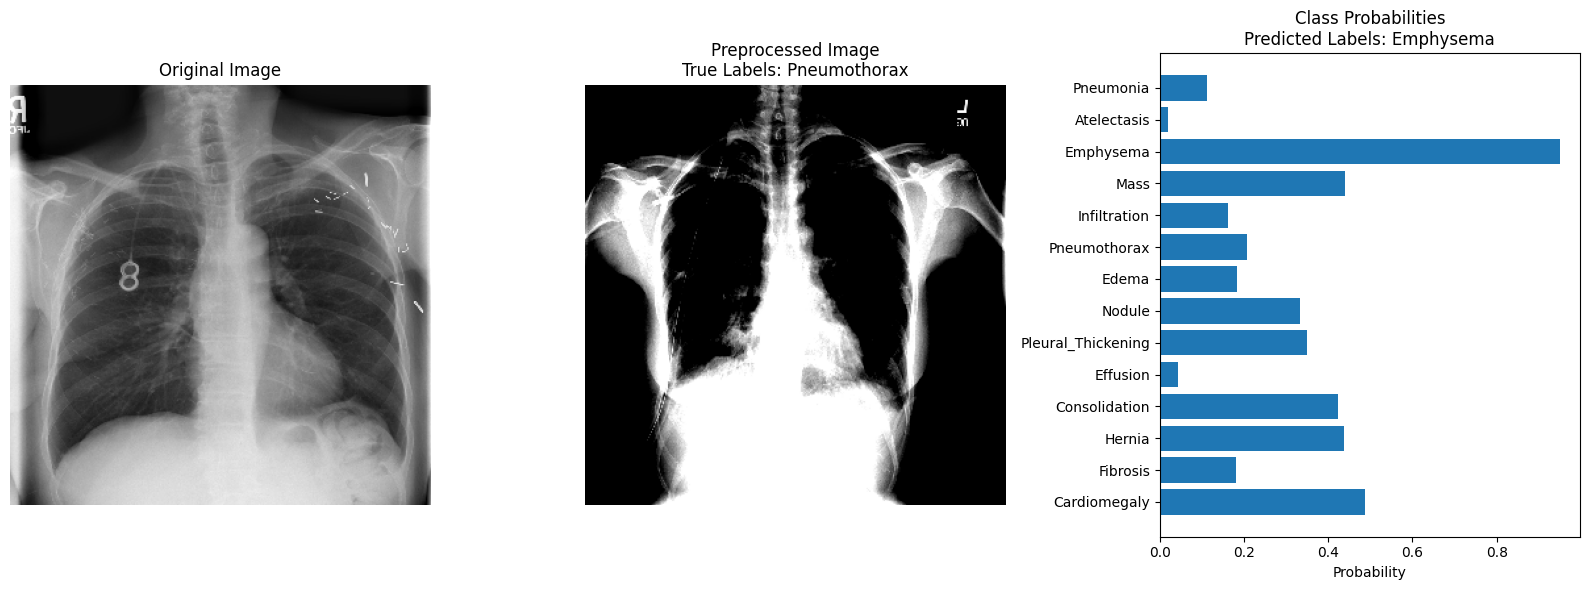

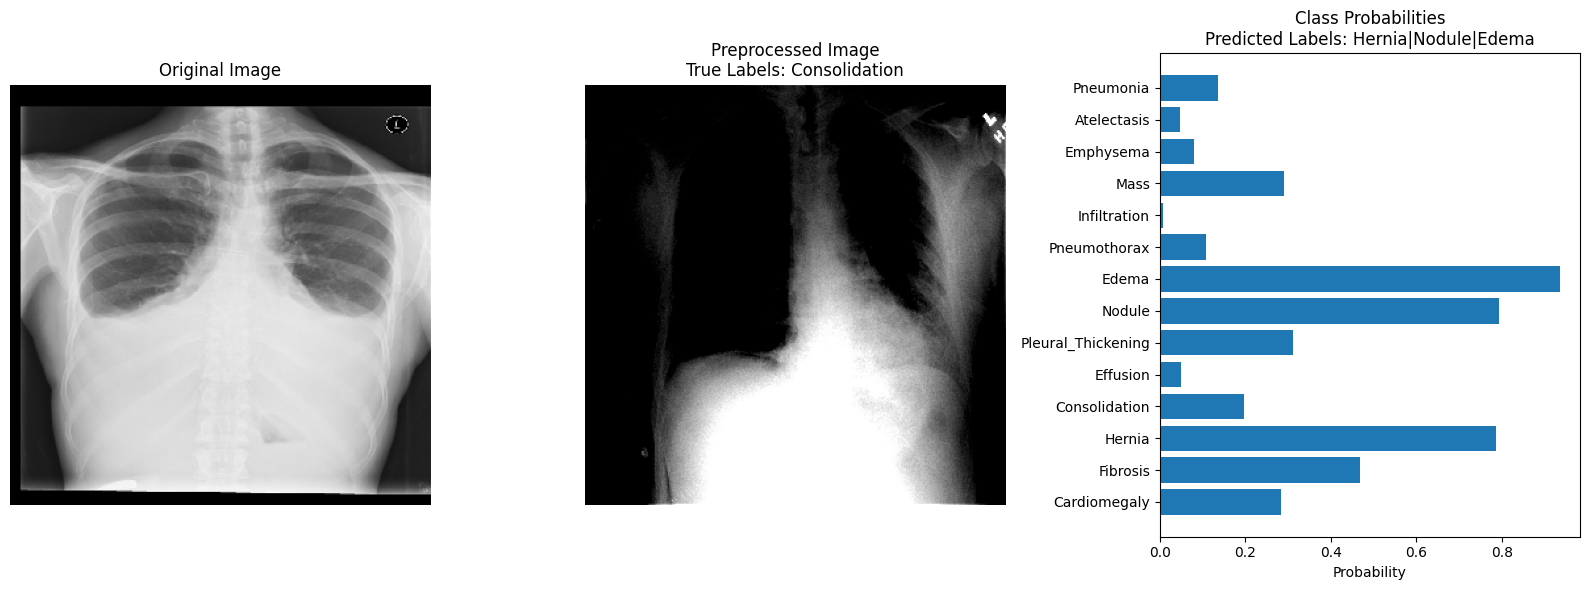

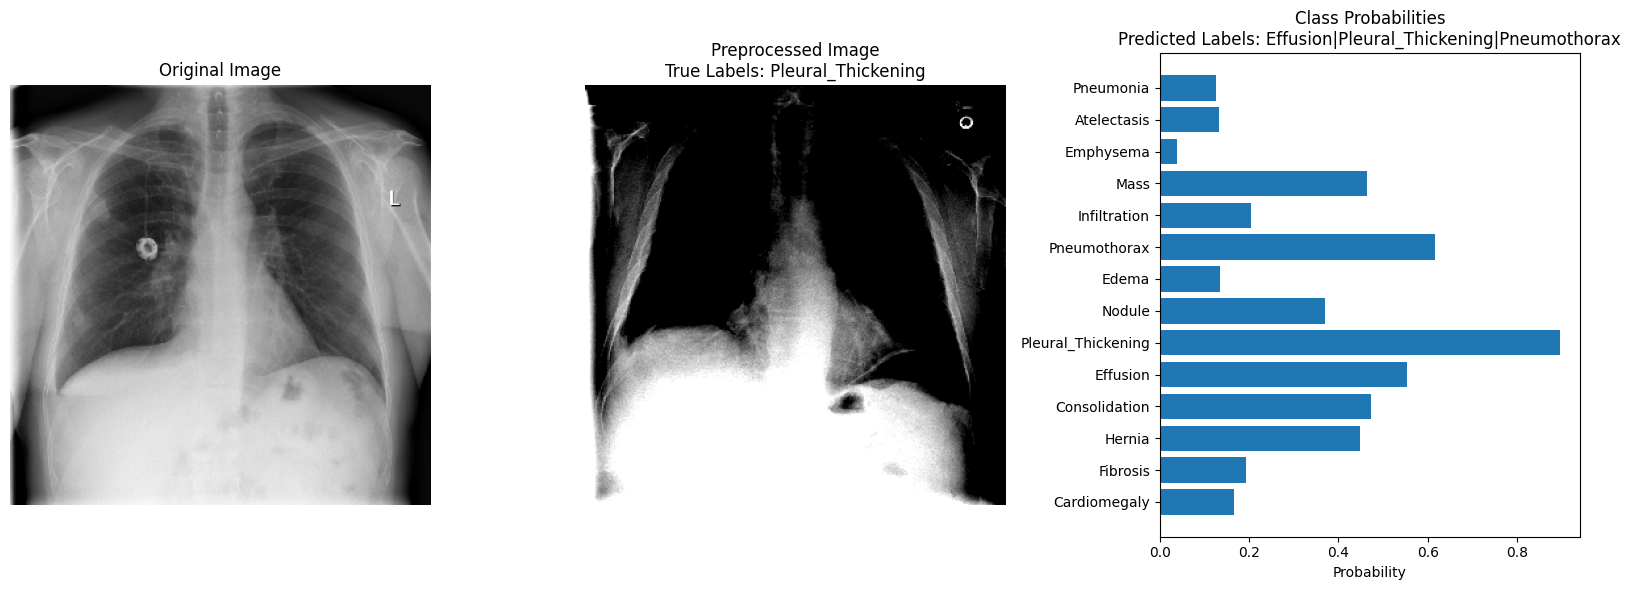

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Función para obtener los nombres de las etiquetas (reales o predichas)
def get_label(y, threshold=0.5):
    """
    Devuelve las etiquetas correspondientes a las clases activas (1 o prob > threshold).

    y (list or array): vector binario o de probabilidades de una muestra
    threshold (float): umbral para decidir si una clase está presente o no
    """
    ret_labels = []
    for i, value in enumerate(y):
        if value >= threshold:
            ret_labels.append(labels[i])
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

# Obtener un batch de imágenes preprocesadas y las etiquetas verdaderas
images, labels_true = next(test_generator)

# Seleccionar aleatoriamente 3 imágenes del batch
random_indices = np.random.choice(len(images), 3, replace=False)
random_images = images[random_indices]
random_labels = labels_true[random_indices]

# Predecir las probabilidades de clase para las imágenes seleccionadas
predictions = model.predict(random_images)

# Mostrar imágenes con las etiquetas verdaderas y las predicciones
for i, idx in enumerate(random_indices):
    plt.figure(figsize=(16, 6))

    # Cargar la imagen original (antes del preprocesamiento)
    original_image_path = df_test.iloc[idx]['filepath']
    original_image = load_img(original_image_path, target_size=(320, 320))  # Ajustar según el preprocesamiento

    # Mostrar imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image")

    # Mostrar imagen preprocesada
    plt.subplot(1, 3, 2)
    plt.imshow(random_images[i])
    plt.axis('off')
    # Etiquetas verdaderas para esta imagen
    true_labels = get_label(random_labels[i])
    plt.title(f"Preprocessed Image\nTrue Labels: {true_labels}")

    # Mostrar las probabilidades de clase predichas
    plt.subplot(1, 3, 3)
    plt.barh(range(len(labels)), predictions[i])
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Probability")
    # Etiquetas predichas para esta imagen
    predicted_labels = get_label(predictions[i], threshold=0.5)
    plt.title(f"Class Probabilities\nPredicted Labels: {predicted_labels}")

    plt.tight_layout()

    plt.show()



# **5. Grad-CAM: Model explainability**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [47]:
# DenseNet121: The final convolutional layer could be conv5_block16_2_conv or similar.
# EfficientNet: The last convolutional layer might be something like top_conv.

In [48]:
# Extraer 4 rutas aleatorias de la columna 'filepath' y almacenarlas en test_image_paths
test_image_paths = df_test['filepath'].sample(4).tolist()

# Mostrar las rutas seleccionada
test_image_paths


['/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/test/00011632_031.png',
 '/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/test/00020716_006.png',
 '/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/test/00018921_051.png',
 '/content/drive/My Drive/Data_Science_Repo_Data/medical_imaging/test/00008806_012.png']

1/1 [==============================] - 0s 118ms/step


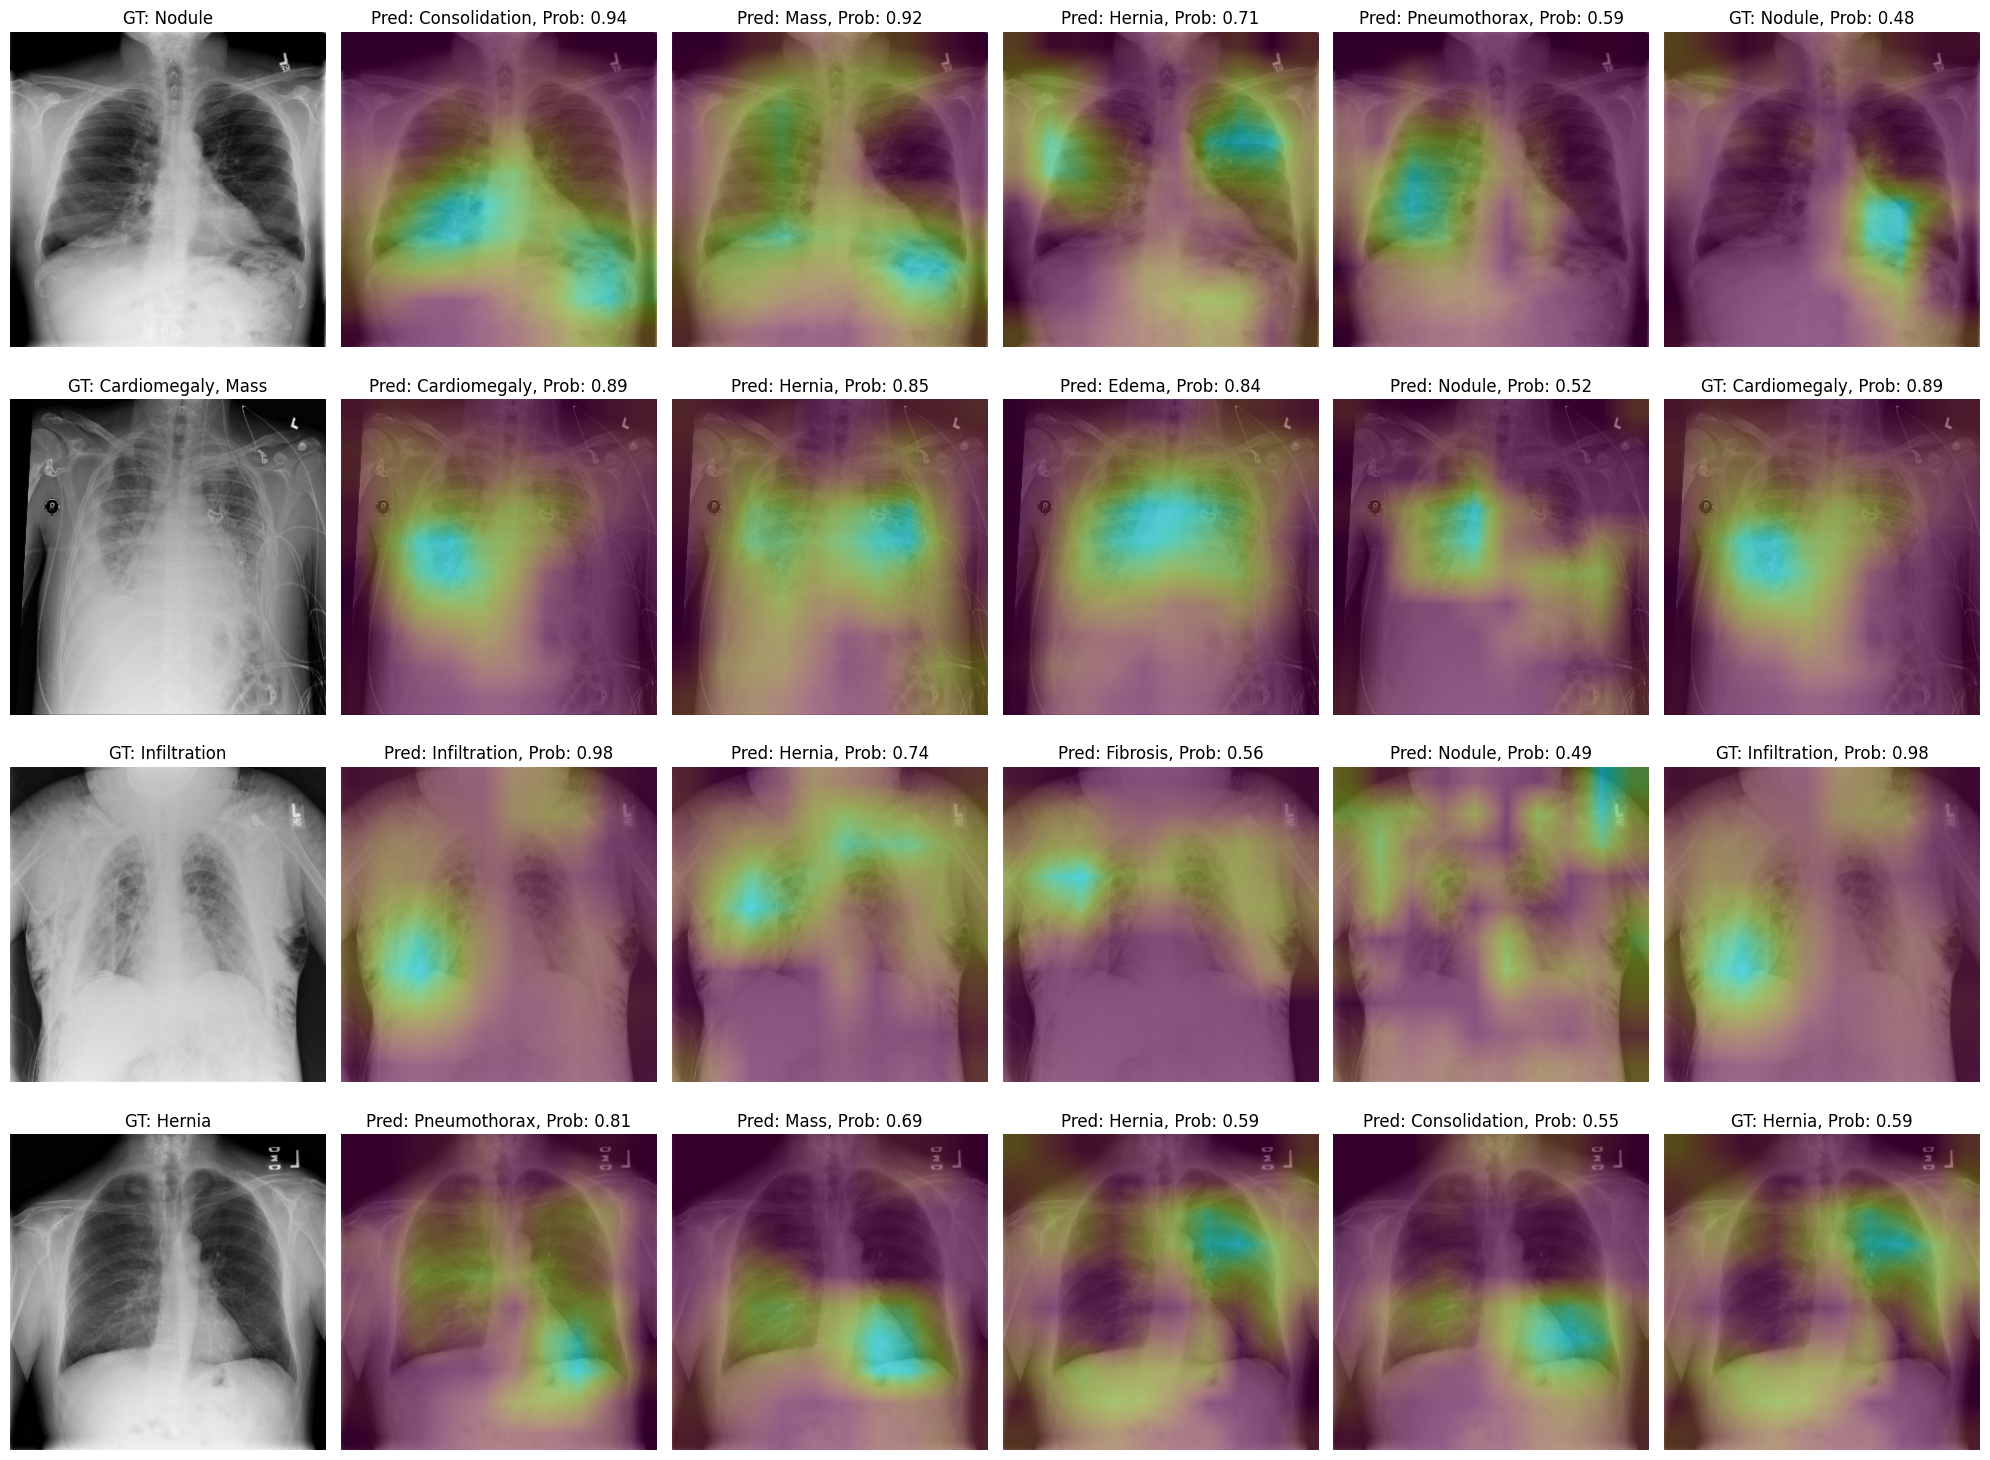

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random

# Define ImageDataGenerator with the correct preprocessing function (without augmentation)
test_datagen = datagen_no_aug

# Function to generate Grad-CAM heatmaps
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Adjust the colormap for Grad-CAM
def superimpose_heatmap_on_image(img, heatmap, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(heatmap, 0.6, img, 0.4, 0)  # Adjust the intensity as needed
    return superimposed_img

# Plot Grad-CAM for multiple test images with ground truth and prediction labels (multilabel)
def plot_gradcam_on_test_images(test_image_paths, test_generator, model, last_conv_layer_name, all_labels, top_classes=4):
    # Se agrega una columna más para las etiquetas ground truth
    fig, axs = plt.subplots(len(test_image_paths), top_classes + 2, figsize=(20, 15))

    # Obtener todas las imágenes y etiquetas del generador
    all_image_paths = test_generator.filenames

    # Mapeo entre rutas de imagen y etiquetas
    image_to_label_map = {img_path: label for img_path, label in zip(all_image_paths, test_generator.labels)}

    for i, img_path in enumerate(test_image_paths):
        # Load and preprocess the image using OpenCV
        img_full_path = f"{test_generator.directory}/{img_path}"  # Combinar con la ruta base del directorio
        img = cv2.imread(img_full_path)  # Leer imagen
        img_resized = cv2.resize(img, (320, 320))  # Redimensionar a 320x320

        # Convertir la imagen a float32 antes de la estandarización
        img_array = np.expand_dims(img_resized.astype('float32'), axis=0)  # Añadir solo una dimensión batch

        # Aplicar el preprocesamiento del generador sin aumentación
        img_array = test_datagen.standardize(img_array)

        # Obtener la etiqueta de la imagen desde el mapeo
        true_label = image_to_label_map[img_path]

        # Obtener las predicciones del modelo
        preds = model.predict(img_array)
        top_pred_classes = np.argsort(preds[0])[-top_classes:][::-1]

        # Mostrar la imagen original con las etiquetas ground truth (usando los nombres de las etiquetas activas)
        true_labels_text = ', '.join([all_labels[j] for j, val in enumerate(true_label) if val == 1])
        predicted_labels_text = ', '.join([f"{all_labels[class_idx]}:{preds[0][class_idx]:.2f}" for class_idx in top_pred_classes])
        axs[i, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"GT: {true_labels_text}")

        # Crear y plotear heatmaps para las top clases predichas
        for j, class_idx in enumerate(top_pred_classes):
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=class_idx)
            superimposed_img = superimpose_heatmap_on_image(img_resized, heatmap, colormap=cv2.COLORMAP_VIRIDIS)  # Adjust colormap

            # Mostrar la imagen con el heatmap Grad-CAM superpuesto
            axs[i, j + 1].imshow(superimposed_img.astype('uint8'))
            axs[i, j + 1].axis('off')
            axs[i, j + 1].set_title(f"Pred: {all_labels[class_idx]}, Prob: {preds[0][class_idx]:.2f}")

        # Grad-CAM para la clase ground truth
        true_class_idx = np.argmax(true_label)  # Suponiendo una etiqueta verdadera activa
        heatmap_gt = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=true_class_idx)
        superimposed_img_gt = superimpose_heatmap_on_image(img_resized, heatmap_gt, colormap=cv2.COLORMAP_VIRIDIS)

        axs[i, top_classes + 1].imshow(superimposed_img_gt.astype('uint8'))
        axs[i, top_classes + 1].axis('off')
        axs[i, top_classes + 1].set_title(f"GT: {all_labels[true_class_idx]}, Prob: {preds[0][true_class_idx]:.2f}")

    plt.tight_layout()
    plt.show()

# Seleccionar 4 imágenes aleatorias de las rutas
test_image_paths = random.sample(test_generator.filenames, 4)

# Plot Grad-CAM heatmaps para las imágenes seleccionadas aleatoriamente, incluyendo el Grad-CAM de la clase ground truth
plot_gradcam_on_test_images(test_image_paths, test_generator, model, last_conv_layer_name="conv5_block16_concat", all_labels=all_labels)
